In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
sts_dic = {}
sts_dic

{}

In [4]:
# 1) get overlap at gene level
gff = '/data/genome/hamster/ncbi_refseq/hamster.gff'
gff_df = pd.read_csv(gff,sep='\t',header=None,comment='#',names=['chr','s',
                    'feature','start','end','dot','strand','none','anno'])
gff_df = gff_df.drop(['s','dot','none'],axis=1)


In [5]:
def cds_anno_prid(anno):
    try:
        return re.search('(?<=protein_id=).+?(?=;|$)',anno).group()
    except:
        return 'No'
cds_df = gff_df[gff_df['feature'].values=='CDS']
cds_df.loc[:,'rna_index']=cds_df['anno'].apply(lambda x: re.search('(?<=Parent=).+?(?=;)',x).group())
cds_df = cds_df[cds_df['rna_index'].apply(lambda x: 'rna' in x)]
cds_df = cds_df.reset_index(drop=True)
cds_df.loc[:,'protein_accession'] = cds_df['anno'].apply(lambda x: cds_anno_prid(x))
exon_df = gff_df[gff_df['feature'].values=='exon']
exon_df.loc[:,'rna_index']=exon_df['anno'].apply(lambda x: re.search('(?<=Parent=).+?(?=;)',x).group())
exon_df = exon_df[exon_df['rna_index'].apply(lambda x: 'rna' in x)]
exon_df = exon_df.reset_index(drop=True)


/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
##------- process rna data frame ---------
def rna_utr(row,cds_df):
    strand = row['strand']
    pr_df = cds_df[cds_df['rna_index'].values==row['rna_index']]
    if pr_df.empty:
        row[['5UTR','3UTR']] = ['-','-']
        return row
    pr_start = pr_df['start'].tolist()[0]
    pr_end = pr_df['end'].tolist()[-1]
    if pr_start == row['start']: row['5UTR']='F'
    if pr_end == row['end']: row['3UTR']='F'
    if strand=='-':
        row[['5UTR','3UTR']] = row[['5UTR','3UTR']]
    return row
rna_df = gff_df[gff_df['feature'].values=='mRNA']
rna_df = rna_df.reset_index(drop=True)
sts_dic['total_number_mRNA'] = rna_df.shape[0]
rna_df.loc[:,'geneid'] = rna_df['anno'].apply(lambda x:re.search('(?<=GeneID:).+?(?=[,;]|$)',x).group())
rna_df.loc[:,'rna_accession'] = rna_df['anno'].apply(lambda x: re.search('(?<=transcript_id=).+?(?=[,;]|$)',x).group())
rna_df.loc[:,'rna_index'] = rna_df['anno'].apply(lambda x: re.search('(?<=ID=).+?(?=;)',x).group())
# add protein accession column
rna_pr_df = cds_df[['rna_index','protein_accession']].drop_duplicates()
rna_pr_dic = {k:list(v) for k,v in rna_pr_df.groupby('rna_index')['protein_accession']}
rna_df.loc[:,'protein_accession']=rna_df['rna_index'].apply(lambda x: 
                                ','.join(rna_pr_dic[x]) if x in rna_pr_dic else 'No')
# add statistic information
temp = rna_df[rna_df['protein_accession'].values !='No']
sts_dic['total_number_proteins']=len(set(temp['protein_accession'].tolist()))
sts_dic['mRNA_number_with0_protein'] = rna_df[rna_df['protein_accession'].values =='No'].shape[0]
temp = rna_pr_df[rna_pr_df['protein_accession'].values !='No']
temp = temp.groupby('protein_accession').size()
sts_dic['protein_number_encoded_by_many_mRNA_because_gene_mapping2manyScaffold'] = temp[temp>1].shape[0]
# add UTR information (have or not)
rna_df = rna_df.reindex(columns=rna_df.columns.tolist()+['5UTR','3UTR'],fill_value='T')
rna_df = rna_df.apply(lambda row: rna_utr(row,cds_df),axis=1) # 5 minutes
sts_dic['mRNA_number_with_5UTR'] = rna_df[rna_df['5UTR'].values=='T'].shape[0]
sts_dic['mRNA_number_with_3UTR'] = rna_df[rna_df['3UTR'].values=='T'].shape[0]
sts_dic['mRNA_number_with_5&3UTR']=rna_df[(rna_df['3UTR'].values=='T') & (rna_df['5UTR'].values=='T')].shape[0]

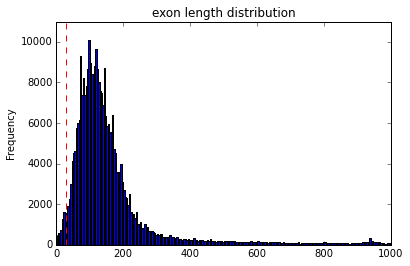

In [7]:
# exon length distribution
exon_df.loc[:,'len'] = exon_df['end']-exon_df['start'] 
ax = exon_df['len'].plot(kind='hist',bins=5000,title='exon length distribution')
ax.set_xlim([0,1000])
ax.set_ylim([0,11000])
ax.axvline(30,color='red',linestyle='--')
plt.show()

In [8]:
#-------------- process gene dataframe --------------
# add geneid and gene symbol column
gene_df = gff_df[gff_df['feature'].values=='gene']
gene_number = gene_df.shape[0]
sts_dic['total_number_of_genes'] = gene_number
gene_df = gene_df.reset_index(drop=True)
gene_df.loc[:,'gene'] = gene_df['anno'].apply(lambda x: re.search('(?<=gene=).+?(?=;|$)',x).group())
gene_df.loc[:,'geneid'] = gene_df['anno'].apply(lambda x: re.search('(?<=GeneID:).+?(?=[;,]|$)',x).group())
gene_df.loc[:,'gene_index'] = gene_df['anno'].apply(lambda x: re.search('(?<=ID=).+?(?=;)',x).group())
# add number of mRNAs
gene_rna_dic = {k:list(v) for k,v in rna_df.groupby('geneid')['rna_accession']}
gene_df.loc[:,'rna_number'] = gene_df['geneid'].apply(lambda x: len(gene_rna_dic[x]) if x in 
                                                    gene_rna_dic else 0)
sts_dic['gene_number_with0_rna'] = gene_df[gene_df['rna_number'].values==0].shape[0]
sts_dic['gene_number_with1_rna'] = gene_df[gene_df['rna_number'].values==1].shape[0]
sts_dic['gene_number_with_many_rna'] = gene_df[gene_df['rna_number'].values>1].shape[0]
# add map to multiple scaffold
gene_chr_dic = {k:list(v) for k,v in gene_df.groupby('geneid')['chr']}
gene_df.loc[:,'map2many_scaffold'] = gene_df['geneid'].apply(lambda x: 'T' if len(gene_chr_dic[x])>1 else 'F')
sts_dic['gene_number_map2many_scaffold'] = gene_df[gene_df['map2many_scaffold'].values=='T'].shape[0]

In [46]:
# add gene encode proteins or not
def verify_gene_encode_pr(geneid,gene_rna_dic,rna_pr_dic):
    try:
        rnas = gene_rna_dic[geneid]
        for rna in rnas:
            try:
                pr = rna_pr_dic[rna]
                if pr != []:
                    return 'T'
                else:
                    return 'F'
            except:
                return 'F'
    except:
        return 'F'
gene_df.loc[:,'encode_protein'] = gene_df['geneid'].apply(lambda x: verify_gene_encode_pr(x,gene_rna_dic,rna_pr_dic))
sts_dic['gene_number_encode_protein']=gene_df[gene_df['encode_protein'].values=='T'].shape[0]
gene_df

,chr,feature,start,end,strand,anno,gene,geneid,gene_index,rna_number,map2many_scaffold,overlap_in_same_strand_gene_level,overlap_in_diff_strand_gene_level,encode_protein
0,NW_006834823.1,gene,56,195,+,ID=gene0;Dbxref=GeneID:103159068;Name=LOC10315...,LOC103159068,103159068,gene0,0,F,F,F,F
1,NW_006841010.1,gene,16,186,+,ID=gene1;Dbxref=GeneID:103159065;Name=LOC10315...,LOC103159065,103159065,gene1,0,F,F,F,F
2,NW_006844571.1,gene,66,230,-,ID=gene2;Dbxref=GeneID:103159062;Name=LOC10315...,LOC103159062,103159062,gene2,1,F,F,F,F
3,NW_006846156.1,gene,4,237,-,ID=gene3;Dbxref=GeneID:103159069;Name=LOC10315...,LOC103159069,103159069,gene3,1,F,F,F,F
4,NW_006846938.1,gene,7,242,-,ID=gene4;Dbxref=GeneID:100756595;Name=LOC10075...,LOC100756595,100756595,gene4,1,F,F,F,F
5,NW_006848634.1,gene,22,250,-,ID=gene5;Dbxref=GeneID:103159070;Name=LOC10315...,LOC103159070,103159070,gene5,1,F,F,F,F
6,NW_006848864.1,gene,1,254,+,ID=gene6;Dbxref=GeneID:103159071;Name=LOC10315...,LOC103159071,103159071,gene6,0,F,F,F,F
7,NW_006849117.1,gene,42,221,-,ID=gene7;Dbxref=GeneID:103159061;Name=LOC10315...,LOC103159061,103159061,gene7,1,F,F,F,F
8,NW_006850911.1,gene,4,267,+,ID=gene8;Dbxref=GeneID:100751687;Name=LOC10075...,LOC100751687,100751687,gene8,0,F,F,F,F
9,NW_006853466.1,gene,9,277,+,ID=gene9;Dbxref=GeneID:103159072;Name=LOC10315...,LOC103159072,103159072,gene9,0,F,F,F,F


In [10]:
def gene_overlap_test(row,gene_df):
    strand = row['strand']
    chrom = row['chr']
    temp_df = gene_df[(gene_df['chr'].values==chrom) & (gene_df['geneid'].values !=row['geneid'])]
    if temp_df.empty:
        return row
    temp_df['keep'] = temp_df.apply(lambda x: (x['start']<=row['end']) & (x['end']>=row['start']),axis=1)
    temp_df = temp_df[temp_df['keep'].values==True]
    if temp_df.empty:
        return row
    else:
        same = temp_df[temp_df['strand'].values==strand]
        diff = temp_df[temp_df['strand'].values!=strand]
        if not same.empty:
            row['overlap_in_same_strand_gene_level'] = ','.join(same['geneid'].tolist())
        if not diff.empty:
            row['overlap_in_diff_strand_gene_level'] = ','.join(diff['geneid'].tolist())
        return row
# add gene overlap with genes at gene level in same strand
gene_df = gene_df.reindex(columns=gene_df.columns.tolist()+['overlap_in_same_strand_gene_level',
                        'overlap_in_diff_strand_gene_level'],fill_value='F')
import time
start = time.time()
#gene_df = gene_df.drop(['overlap_in_same_strand_gene_level'],axis=1)
res = gene_df.apply(lambda row: gene_overlap_test(row,gene_df),axis=1)
#res = gene_overlap_test(gene_df.loc[1,:],gene_df)
print time.time() - start
res

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13806.4138122


,chr,feature,start,end,strand,anno,gene,geneid,gene_index,rna_number,map2many_scaffold,overlap_in_same_strand_gene_level,overlap_in_diff_strand_gene_level
0,NW_006834823.1,gene,56,195,+,ID=gene0;Dbxref=GeneID:103159068;Name=LOC10315...,LOC103159068,103159068,gene0,0,F,F,F
1,NW_006841010.1,gene,16,186,+,ID=gene1;Dbxref=GeneID:103159065;Name=LOC10315...,LOC103159065,103159065,gene1,0,F,F,F
2,NW_006844571.1,gene,66,230,-,ID=gene2;Dbxref=GeneID:103159062;Name=LOC10315...,LOC103159062,103159062,gene2,1,F,F,F
3,NW_006846156.1,gene,4,237,-,ID=gene3;Dbxref=GeneID:103159069;Name=LOC10315...,LOC103159069,103159069,gene3,1,F,F,F
4,NW_006846938.1,gene,7,242,-,ID=gene4;Dbxref=GeneID:100756595;Name=LOC10075...,LOC100756595,100756595,gene4,1,F,F,F
5,NW_006848634.1,gene,22,250,-,ID=gene5;Dbxref=GeneID:103159070;Name=LOC10315...,LOC103159070,103159070,gene5,1,F,F,F
6,NW_006848864.1,gene,1,254,+,ID=gene6;Dbxref=GeneID:103159071;Name=LOC10315...,LOC103159071,103159071,gene6,0,F,F,F
7,NW_006849117.1,gene,42,221,-,ID=gene7;Dbxref=GeneID:103159061;Name=LOC10315...,LOC103159061,103159061,gene7,1,F,F,F
8,NW_006850911.1,gene,4,267,+,ID=gene8;Dbxref=GeneID:100751687;Name=LOC10075...,LOC100751687,100751687,gene8,0,F,F,F
9,NW_006853466.1,gene,9,277,+,ID=gene9;Dbxref=GeneID:103159072;Name=LOC10315...,LOC103159072,103159072,gene9,0,F,F,F


In [ ]:
# add overlap in transcript level


In [59]:
# output dataframes into mysql database
import sqlite3
conn = sqlite3.connect('/data/shangzhong/Proteogenomics/Results/04_old_hamster_gff.db')

gene_df.to_sql('gene_table',con=conn,if_exists='replace',index=False,index_label='gene_index')
rna_df.to_sql('rna_table',con=conn,if_exists='replace',index=False,index_label='rna_index')

In [ ]:
# build annotation file

In [73]:
import pandas as pd
import os
desp = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_rnaseq/picr_db_rna.pasa_assemblies_described.txt'
# build trid:tr_accession dictionary
tr_acc_dic = {} # {trid:tr_accession}
with open(desp) as f:
    for line in f:
        item = line.strip().split('\t')
        access = item[3].split(',')
        tr_ac = [a for a in access if not a.startswith('MSTRG')]
        if tr_ac == []:
            tr_acc_dic[item[2]] = access[0]
        else:
            tr_acc_dic[item[2]] = tr_ac[0].split('.')[0]

In [134]:
tr_acc_dic

{'asmbl_22997': 'MSTRG.7413.2',
 'asmbl_22996': 'MSTRG.7413.1',
 'asmbl_22995': 'MSTRG.7412.1',
 'asmbl_22994': 'XM_016966422',
 'asmbl_22993': 'XM_007615243',
 'asmbl_22992': 'MSTRG.7410.2',
 'asmbl_22991': 'XR_479233',
 'asmbl_22990': 'XR_479232',
 'asmbl_50215': 'MSTRG.16637.1',
 'asmbl_72591': 'XM_007619910',
 'asmbl_44222': 'MSTRG.14539.1',
 'asmbl_22999': 'MSTRG.7414.1',
 'asmbl_22998': 'MSTRG.7413.3',
 'asmbl_73789': 'MSTRG.24552.1',
 'asmbl_47681': 'XM_016967709',
 'asmbl_50217': 'XM_016970412',
 'asmbl_57620': 'XM_016971702',
 'asmbl_50216': 'MSTRG.16638.1',
 'asmbl_45148': 'MSTRG.14851.6',
 'asmbl_27819': 'XM_016965955',
 'asmbl_27818': 'XM_007608401',
 'asmbl_66502': 'XM_007632076',
 'asmbl_27811': 'MSTRG.9142.1',
 'asmbl_27810': 'MSTRG.9141.1',
 'asmbl_27813': 'MSTRG.9142.3',
 'asmbl_27812': 'MSTRG.9142.2',
 'asmbl_27815': 'MSTRG.9142.5',
 'asmbl_27814': 'MSTRG.9142.4',
 'asmbl_27817': 'MSTRG.9143.1',
 'asmbl_27816': 'XM_007613506',
 'asmbl_63302': 'MSTRG.21010.11',
 'asmbl

In [74]:
def get_trpr_pos_dic(gff,feature,pattern):
    '''build dictionary {accession:[chrom,strand,(start,end),...]}'''
    pos_dic = {}
    low_qual_ac = []
    with open(gff) as f:
        for line in f:
            if line.strip() == '': continue # skip empty line
            item = line.strip().split('\t')
            if item[2] != feature:
                continue
            chrom = item[0]
            anno = item[8]
            strand = item[6]
            ac = re.search(pattern,anno).group(0)
            start = int(item[3]);end=int(item[4])
            if ac not in pos_dic:
                pos_dic[ac] = [chrom,strand,(start,end)]
            else:
                if chrom != pos_dic[ac][0]:
                    low_qual_ac.append(ac)
                    continue
                pos_dic[ac].append((start,end))
    low_qual_ac = list(set(low_qual_ac))
    filter_pos_dic = {k:v for k,v in pos_dic.iteritems() if k not in low_qual_ac}
    return pos_dic,low_qual_ac

In [93]:
#-------- build {tr:[chr,str,(s1,e1),(s2,e3)...]}
pasa_assemble = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_rnaseq/picr_db_rna.assemblies.fasta.transdecoder.genome.gff3'
tr_pos_dic,low_qual_tr = get_trpr_pos_dic(pasa_assemble,'exon','(?<=ID=).+?(?=\|)')
#-------- build {pr:[chr,str,(s1,e1),(s2,e2)...]}
exonerate_gff = '/data/shangzhong/Picr_assembly/Annotation/exonerate/exonerate.gff'
pr_pos_dic,low_qual_pr = get_trpr_pos_dic(exonerate_gff,'cds_match','(?<=Target=).+?(?=\.)')
# transfer tr_id to tr_accession
tr_pos_dic = {tr_acc_dic[k]:v for k,v in tr_pos_dic.iteritems()}

In [130]:
tr_g_dic ={}
with open(pasa_assemble) as f:
    for line in f:
        if line.strip() == '': continue
        item = line.strip().split('\t')
        if item[2] == 'gene':
            tr_g = item[8][3:].split(';')[0].split('|')
            if tr_g[0] in tr_g_dic:
                tr_g_dic[tr_g[0]].append(tr_g[1])
            else:
                tr_g_dic[tr_g[0]] = [tr_g[1]]

In [114]:
# build gene, traccess, pr access mapping
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'
def gene_rna_pr_id_map(hamster_id,access,out_fn):
    '''this fnction get all gene rna pr id, including both refseq and gff information.
    * hamster_id: a file that has all ids in hamster.gff file
    * access
    * out_fn:  
    '''
    # rna accession in gff file
    ham_id_df = pd.read_csv(hamster_id,sep='\t',header=0)
    ham_id_df = ham_id_df.astype('str')
    ham_id_df['TrAccess'] = ham_id_df['TrAccess'].map(lambda x: x.split('.')[0])
    ham_id_df['PrAccess'] = ham_id_df['PrAccess'].map(lambda x: x.split('.')[0])
    rna_gene_dic = ham_id_df.set_index('TrAccess')['GeneID'].to_dict()
    rna_pr_dic = ham_id_df.set_index('TrAccess')['PrAccess'].to_dict()
    rna_gname_dic = ham_id_df.set_index('TrAccess')['GeneSymbol'].to_dict()
    # new rna in refseq compared to gff
    new_ref_rna = list(set(access) - set(rna_gene_dic.keys()))
    # get geneid for new ref_rna gene id
    for r in new_ref_rna:
        if r.startswith('MSTRG'):
            rna_gene_dic[r] = '.'.join(r.split('.')[:2])
            rna_pr_dic[r] = '-'
            rna_gname_dic[r] = '.'.join(r.split('.')[:2])
        else:
            handle = Entrez.efetch(db='nucleotide',id=r,rettype='gb',retmode='text').read()
            
            geneid = re.search('(?<=GeneID:).+?(?=\")',handle).group(0)
            gename = re.search('(?<=gene=\").+?(?=\")',handle).group(0)
            try:
                p = re.search('(?<=protein_id=\").+?(?=\.)',handle).group(0)
            except:
                p = '-'
            rna_gene_dic[r] = geneid
            rna_pr_dic[r] = p
            rna_gname_dic[r] = gename
    # transfer dic to dataframe
    r_g_df = pd.DataFrame.from_dict(rna_gene_dic,'index')
    r_g_df.columns = ['geneid']
    r_p_df = pd.DataFrame.from_dict(rna_pr_dic,'index')
    r_p_df.columns = ['pr_ac']
    r_n_df = pd.DataFrame.from_dict(rna_gname_dic,'index')
    r_n_df.columns = ['gename']
    g_r_p_df = pd.concat([r_g_df,r_n_df,r_p_df],axis=1)
    g_r_p_df['rna_ac'] = g_r_p_df.index
    g_r_p_df[['geneid','gename','rna_ac','pr_ac']].to_csv(out_fn,sep='\t',index=False)

In [115]:
#------------- get gene, tr, pr id mapping
hamster_id = '/data/shangzhong/Database/hamster/hamster_all_id.txt'
out_fn = '/data/shangzhong/Picr_assembly/Annotation/pasa_exonerate/01_gene_tr_pr.txt'
if not os.path.exists(out_fn):
    gene_rna_pr_id_map(hamster_id,tr_pos_dic.keys(),out_fn)

In [128]:
#-------- build {pasa_pr,[chr,str,(s1,e1),(s2,e2),...]}
pasa_pr_pos_dic,pasa_low_qual_pr = get_trpr_pos_dic(pasa_assemble,'CDS','(?<=Parent=).+?(?=\|)')
# pasa_pr_pos_dic = {rna_pr_dic[tr_acc_dic[k]]:v for k,v in pasa_pr_pos_dic.iteritems()}

In [129]:
n = 0
for pr in pasa_pr_pos_dic.keys():
    if pr == '-':
        n += 1
print(n)
print(len(pasa_pr_pos_dic))

0
57484


In [125]:
# find perfect tr and pr splice sites.
map_df = pd.read_csv(out_fn,sep='\t',header=0)
rna_pr_dic = map_df.set_index('rna_ac')['pr_ac'].to_dict()
rna_geneid_dic = map_df.set_index('rna_ac')['geneid'].to_dict()
rna_gename_dic = map_df.set_index('rna_ac')['gename'].to_dict()
trpr_perfect_match = {}
for tr in tr_pos_dic.keys():
    pr = rna_pr_dic[tr]
    if pr == '-':
        continue
    if pr in pr_pos_dic:
        # compare if rna nd protein are in the same strand and same direction
        tr_pos = tr_pos_dic[tr]
        pr_pos = pr_pos_dic[pr]
        if tr_pos[:2] == pr_pos[:2]: # same strand, same chromosome
            tr_boundary = sorted([i for sub in tr_pos[2:] for i in sub])
            pr_boundary = sorted([i for sub in pr_pos[2:] for i in sub])[1:-1]
            if set(pr_boundary).issubset(tr_boundary):
                trpr_perfect_match[tr] = pr

In [108]:
merge_gff = '/data/shangzhong/Picr_assembly/Annotation/pasa_exonerate/02_pasa_exonerate.gff'
with open(merge_gff,'w') as fw:
    with open(pasa_assemble) as f:
        for line in f:
            if line.strip() == '' or line.startswith('#'):
                continue
            item = line.strip().split('\t')
        anno = item[8]
        if item[2] in ['gene','mRNA','exon','five']:
            tr = re.search('(?<=).+?(?=|)',anno).group(0)
        else if item[2] == :
            tr = re.search
            
            gene_id = rna_ge_dic[tr]
            gene_name = rna_gename_dic[tr]
            item[8] = anno.split(';')[0]+';geneid='+gene_id+';Name='+gene_name
            
        if item[2] == 'mRNA':
            tr = re.search('(?<=).+?(?=|)',anno).group(0)
        fw.write('\t'.join(item)+'\n')
            

20245

In [ ]:
# import re
# pasa_df = pd.read_csv(pasa_assemble,sep='\t',header=None,comment='#')
# pasa_df['anno'] = pasa_df[8].map(lambda x: x+';transcript_id='+tr_acc_dic[re.search('(?<=Target=).+?(?=\ )',x).group(0)])
from Bio import SeqIO
fn = '/data/genome/hamster/picr_old/picr.fa'
dic = SeqIO.index(fn,'fasta')

In [42]:
fn = '/home/shangzhong/cho_uniprot.txt'
df = pd.read_csv(fn,header=None,names=['uniprot'])
uni_ids = df['uniprot'].tolist()

In [41]:
map_fn = '/home/shangzhong/gene_refseq_uniprotkb_collab.gz'
map_df = pd.read_csv(map_fn,sep='\t',compression='gzip',header=0)

In [45]:
res_df = map_df[map_df['UniProtKB_protein_accession'].isin(uni_ids)]

In [61]:
uni_acces_dic = res_df.set_index('UniProtKB_protein_accession')['#NCBI_protein_accession'].to_dict()

In [58]:
id_fn = '/data/genome/hamster/ncbi_refseq/all_id.txt'
id_df = pd.read_csv(id_fn,sep='\t',header=0)
id_df['PrAccess'] = id_df['PrAccess'].map(lambda x: x.split('.')[0])
dic = id_df.set_index('PrAccess')['GeneID'].to_dict()

In [71]:
import re
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'
with open('/home/shangzhong/cho_uniprot_geneid.txt','w') as f:
    for uni in uni_ids:
        try:
            handle = Entrez.efetch(db='protein',id=uni_acces_dic[uni],rettype='gb',retmode='text').read()
            geneid = re.search('(?<=GeneID:).+?(?=\")',handle).group(0)
        except:
            geneid = '-'
        f.write('\t'.join([uni,geneid])+'\n')

In [11]:
import pandas as pd
bst_fn = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/transdecoder/map2hamster.txt'
bst_df = pd.read_csv(bst_fn, sep='\t', header=None)
bst_df[0] = bst_df[0].map(lambda x: x.split('.')[0])
bst_df[1] = bst_df[1].map(lambda x: x.split('.')[0])
pr_refseq_dic = bst_df.set_index(0)[1].to_dict()

In [9]:
from Bio import SeqIO

In [15]:
fa = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/03_pasa_stringtie_pr.fa'
with open(fa) as in1, open('/data/shangzhong/picr_pr.fa','w') as out1:
    for record in SeqIO.parse(fa, 'fasta'):
        if record.id in pr_refseq_dic:
            record.description = record.description + ' Refseq:' + pr_refseq_dic[record.id] 
            SeqIO.write(record, out1,'fasta')
        else:
            SeqIO.write(record, out1,'fasta')

In [5]:
bst_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,asmbl_10.p1,XP_007627977.1,99.351,154,1,0,1,154,1,154,1.180000e-112,321.0,166,277
1,asmbl_100.p1,XP_007610417.1,100.000,239,0,0,1,239,1,239,2.640000e-175,481.0,240,239
2,asmbl_1000.p1,XP_007614478.1,99.567,462,0,1,1,460,1,462,0.000000e+00,934.0,461,462
3,asmbl_10000.p1,XP_016826595.1,100.000,558,0,0,1,558,1,558,0.000000e+00,1165.0,559,558
4,asmbl_10001.p1,XP_016826595.1,97.650,468,11,0,1,468,1,468,0.000000e+00,954.0,485,558


In [1]:
library(GenomicFeatures)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following objects are maske

In [2]:
gff_fn <- '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/03_pasa_stringtie.gff3'

In [4]:
txdb <- makeTxDbFromGFF(gff_fn, format='gff3')

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .extract_exons_from_GRanges(exon_IDX, gr, ID, Name, Parent, feature = "exon", :
“The following orphan exon were dropped (showing only the 6 first):
   seqid   start     end strand                ID      Parent       Name
1 picr_6 5299752 5299832      - asmbl_66487.exon1 asmbl_66487 gene_23425
2 picr_6 5298003 5299628      - asmbl_66487.exon2 asmbl_66487 gene_23425
3 picr_6 5285874 5286007      - asmbl_66487.exon3 asmbl_66487 gene_23425
4 picr_6 5284630 5285049      - asmbl_66487.exon4 asmbl_66487 gene_23425
5 picr_6 5298003 5299699      - asmbl_66488.exon1 asmbl_66488 gene_23425
6 picr_6 5285874 5286007      - asmbl_66488.exon2 asmbl_66488 gene_23425”Warning message in rsqlite_fetch(res@ptr, n = n):
“Don't need to call dbFetch() for statements, only for queries”Warning message:
“RSQLite::dbGetPreparedQuery() is deprecated, please switch t

In [5]:
txdb

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: /data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/03_pasa_stringtie.gff3
# Organism: NA
# Taxonomy ID: NA
# miRBase build ID: NA
# Genome: NA
# transcript_nrow: 82150
# exon_nrow: 331988
# cds_nrow: 216828
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2018-08-23 10:12:19 -0700 (Thu, 23 Aug 2018)
# GenomicFeatures version at creation time: 1.26.4
# RSQLite version at creation time: 2.0
# DBSCHEMAVERSION: 1.1

In [8]:
source("https://bioconductor.org/biocLite.R")
biocLite("ChIPseeker")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
A new version of Bioconductor is available after installing the most recent
  version of R; see http://bioconductor.org/install
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘ChIPseeker’
installation path not writeable, unable to update packages: assertthat,
  backports, BH, BiocParallel, bit64, boot, broom, car, caret, caTools,
  cluster, curl, data.table, DBI, digest, dplyr, evaluate, forcats, foreach,
  foreign, formatR, futile.logger, GenomicAlignments, gistr, glmnet, glue,
  gplots, haven, hexbin, highr, hms, htmlwidgets, httpuv, httr, igraph,
  IRdisplay, iterators, knitr, lattice, lazyeval, lme4, lubridate, maps, MASS,
  Matrix, mgcv, ModelMetrics, modelr, munsell, openssl, packrat, pbdZMQ,
  pkgmaker, PKI, plotrix, pryr, psych, purrr, quantmod, quantreg, R6,
  randomForest, Rcpp, RcppEigen, RCurl, readxl, repr, rlang, rmarkdown,


In [12]:
library('CHIPseeker')

ERROR: Error in library("CHIPseeker"): there is no package called ‘CHIPseeker’
